In [1]:
import itertools

import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd 
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
month = "jan"
country = "BR" # US or BR

shapefile_path = ""
if country == "US":
    shapefile_path = '../data/shapefiles/US/tl_2023_us_county/tl_2023_us_county.shp'
elif country == "BR":
    shapefile_path = '../data/shapefiles/BR/bra_admbnda_adm2_ibge_2020.shp'

#### Obtain lat-lon pairs within study country

<Axes: >

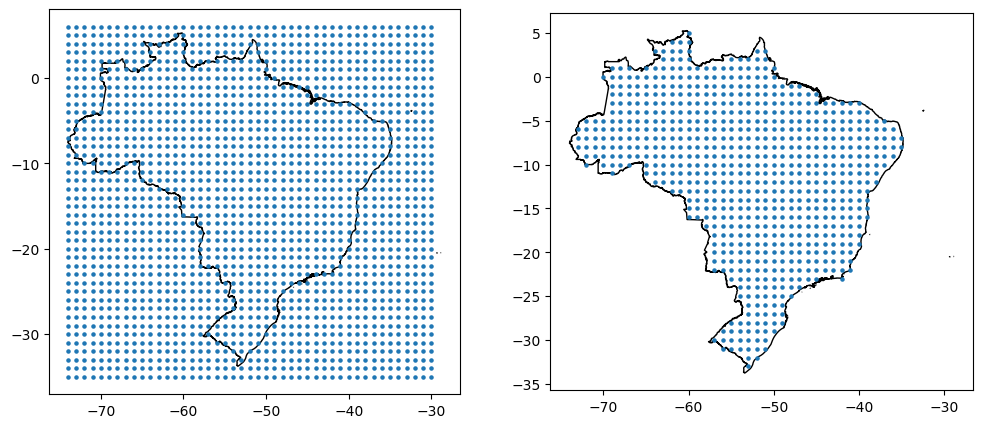

In [3]:
country_gpd = gpd.read_file(shapefile_path, crs="EPSG:4326")
if country == "US":
    country_gpd = country_gpd.cx[-66:-125, 24:50].reset_index(drop=True)
    country_gpd_shape = country_gpd.dissolve().to_crs("EPSG:4326")
else:
    country_gpd_shape = country_gpd.dissolve().set_crs("EPSG:4326")

# Define the latitude and longitude ranges
country_bounds = country_gpd_shape.bounds.values.flatten().astype(int)
latitudes = range(country_bounds[1]-2, country_bounds[3]+2, 1)
longitudes = range(country_bounds[2]-2, country_bounds[0]-2, -1)

# Generate all possible combinations of lat-lon pairs
coordinates = list(itertools.product(latitudes, longitudes))

# Create a GeoDataFrame with point geometries
geometry = gpd.points_from_xy([lon for lat, lon in coordinates], [lat for lat, lon in coordinates])
ecmwf_grid = gpd.GeoDataFrame(geometry=geometry, crs="EPSG:4326")

# Filter ECMWF grid cells by country shape
ecmwf_grid_filtered = ecmwf_grid.sjoin(country_gpd_shape, how="inner")
filtered_coords = pd.DataFrame(data=[ecmwf_grid_filtered.geometry.x.values, ecmwf_grid_filtered.geometry.y.values]).transpose().rename(columns={0: "longitude", 1: "latitude"})

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs = axs.ravel()

country_gpd_shape.plot(ax=axs[0], color='white', edgecolor='black')
ecmwf_grid.plot(ax=axs[0], markersize=5)

country_gpd_shape.plot(ax=axs[1], color='white', edgecolor='black')
ecmwf_grid_filtered.plot(ax=axs[1], markersize=5)

#### Read ECMWF seasonal forecasts

In [4]:
# read hindcasts
list_hindcasts = []
for filename in ["{}_{}_2003_09".format(country.lower(), month), "{}_{}_2010_16".format(country.lower(), month), "{}_{}_2017_23".format(country.lower(), month)]:
    print("reading {}".format(filename))
    df = xr.open_dataset("../data/ECMWF/{}/ecmwf_grib/".format(country) + filename.lower() + ".grib")
    print("ensembles mean") # Note: This is subject to change for probabilistic forecasting
    df = df.mean("number")
    print("to dataframe")
    df = df.to_dataframe().dropna().reset_index()
    print("filter coordinates to country shape")
    df = df.merge(filtered_coords[["latitude", "longitude"]], on=["latitude", "longitude"], how="right")
    print("convert to datetime")
    df["valid_time"] = pd.to_datetime(df["valid_time"])
    df["time"] = pd.to_datetime(df["time"])
    list_hindcasts.append(df)

ecmwf = pd.concat(list_hindcasts, ignore_index=True)

reading br_jan_2003_09
ensembles mean
to dataframe
filter coordinates to country shape
convert to datetime
reading br_jan_2010_16
ensembles mean
to dataframe
filter coordinates to country shape


Can't read index file '../data/ECMWF/BR/ecmwf_grib/br_jan_2017_23.grib.923a8.idx'
Traceback (most recent call last):
  File "c:\Users\Max Zachow\anaconda3\envs\global-yield-forecast\Lib\site-packages\cfgrib\messages.py", line 547, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Max Zachow\anaconda3\envs\global-yield-forecast\Lib\site-packages\cfgrib\messages.py", line 429, in from_indexpath
    index = pickle.load(file)
            ^^^^^^^^^^^^^^^^^
EOFError: Ran out of input


convert to datetime
reading br_jan_2017_23
ensembles mean
to dataframe
filter coordinates to country shape
convert to datetime


## Export to csv

In [7]:
ecmwf.shape

(3210165, 10)

In [9]:
ecmwf.time.min()

Timestamp('2003-01-01 00:00:00')

In [10]:
ecmwf.to_csv("../data/ECMWF/{}/ecmwf_csv/ecmwf_{}.csv".format(country, month), index=False)